In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.integrate import simps

In [2]:
data_path = '../data/CALC_STRAIGHT/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	232


In [4]:
A = pd.read_csv('../data/STRAIGHT_STEP_FREQ.csv')
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,Type
0,N-15-1-Char00part2seg-0.csv,24774.0,25295.0,7.0,7.0,0.017,522.0,8.874,0.788821,0.788821,N
1,N-15-1-Char00part3seg-0.csv,25433.0,26395.0,12.0,13.0,0.017,963.0,16.371,0.733003,0.794087,N
2,N-04-1-Char00part7seg-3.csv,57701.0,59747.0,13.0,14.0,0.008,2047.0,16.376,0.793845,0.854910,N
3,A-736123-Char00part1seg-0.csv,2900.0,4287.0,18.0,18.0,0.017,1388.0,23.596,0.762841,0.762841,A
4,N-15051994-Char00part2seg-0.csv,18500.0,20250.0,13.0,13.0,0.008,1751.0,14.008,0.928041,0.928041,N


In [5]:
def module(joint):
    N = np.size(joint,axis=0)
    module = np.zeros((N))
    for n in range(0,N):
        module[n] = ((joint.iloc[n,0])**2+(joint.iloc[n,1])**2+(joint.iloc[n,2])**2)**(1/2)
    return module

In [10]:
def fft_bands(df,T_sampling,low1,high1,low2,high2):
    Fs = 1.0/T_sampling; # sampling frequency
    n = np.size(df,axis=0) # length of the signal
    
    if n%2==1:
        n-=1
        df = df[:-1]
        
    B = df-np.mean(df,axis=0)   
    
    t = np.arange(0,n*T_sampling,T_sampling) # time vector
        
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range
    
    # Find intersecting values in frequency vector
    idx_delta1 = np.logical_and(frq >= low1, frq < high1)
    idx_delta2 = np.logical_and(frq >= low2, frq < high2)

    Y = np.fft.fft(B)/n # fft computing and normalization
    Y = Y[range(int(n/2))]

    fig, ax = plt.subplots(2, 1,figsize=((16,8)))
    ax[0].plot(t,B)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('|Y(freq)|')
    ax[1].fill_between(frq, abs(Y), where=idx_delta1, color='skyblue',alpha=0.3)
    ax[1].fill_between(frq, abs(Y), where=idx_delta2, color='green',alpha=0.3)
    
    
    # Frequency resolution
    freq_res = frq[1] - frq[0]

    # Compute the absolute power by approximating the area under the curve
    delta_power1 = simps(abs(Y[idx_delta1]), dx=freq_res)
    delta_power2 = simps(abs(Y[idx_delta2]), dx=freq_res)
    
    total_power = simps(abs(Y), dx=freq_res)
    delta_rel_power1 = delta_power1 / total_power
    delta_rel_power2 = delta_power2 / total_power
    print('Absolute delta power: \t band1 %.3f' % delta_power1)
    print('Absolute delta power: \t band2 %.3f' % delta_power2)
    print('Relative delta power: \t band1 %.3f' % delta_rel_power1)
    print('Relative delta power: \t band2 %.3f' % delta_rel_power2)
    
    return delta_rel_power1,delta_rel_power2

N-15-1-Char00part2seg-0.csv
Absolute delta power: 	 band1 0.064
Absolute delta power: 	 band2 0.025
Relative delta power: 	 band1 0.511
Relative delta power: 	 band2 0.202


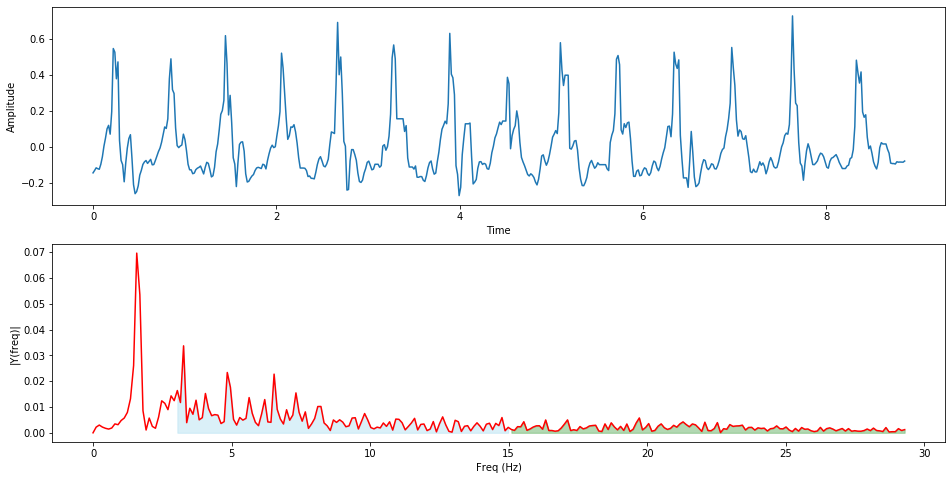

In [11]:
for file in files:
    file = 'N-15-1-Char00part2seg-0.csv'
    energy = np.empty(0)
    
    low1, high1 = 3, 15
    low2, high2 = 15, 30

    print(file)
    
    df = pd.read_csv(data_path + file)
    
    accel_cols = [s for s in df.columns.to_list() if "A" in s]
    adf = df.filter(accel_cols,axis=1)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
    
    AA = pd.DataFrame()
    for joint in range(1,60):
        joint_cols = []
        for col in accel_cols:
            if str(joint) in col:
                joint_cols.append(accel_cols.index(col))
        this_joint = adf.filter(adf.columns[joint_cols],axis=1)
        AA[str(joint)] = module(this_joint)
        
    e1,e2 = fft_bands(AA.iloc[:,0],T_sampling,low1,high1,low2,high2)
    
    '''
    peaksL = np.where(np.diff(df.contactL)>0)[0]
    peaksR = np.where(np.diff(df.contactR)>0)[0]
    
    fig,ax = plt.subplots(2,1,figsize=(16,9))
    ax[0].plot(df.contactL)
    ax[0].plot(peaksL,np.ones_like(peaksL),'o')
    ax[1].plot(df.contactR)
    ax[1].plot(peaksR,np.ones_like(peaksR),'o')
    
    
    if len(peaksL) > len(peaksR):
        steps = peaksL
    else:
        steps = peaksR
        
    # Exclude first and last step (before or after turn)
    start = steps[0]
    steps = steps[1:-1]
    end = steps[1]
    
    for step in steps:
        #print(step)
        end = step
        # select actual step
        a = adf.loc[start:end,:]
        start = end
        
        print(np.size(a,axis=0))
        
        accel_cols = a.columns.to_list()
        AA = pd.DataFrame()
        for joint in range(1,60):
            joint_cols = []
            for col in accel_cols:
                if str(joint) in col:
                    joint_cols.append(accel_cols.index(col))
            this_joint = a.filter(a.columns[joint_cols],axis=1)
            AA[str(joint)] = module(this_joint)
            
        ######### % FREQUENCY IN FREQ BANDS ############
        # input A[joint -> module of acceleration], Tsampling, freq. bands
        # outpus F[joint -> % of energy in band]
        fft_bands(AA,T_sampling,low1,high1,low2,high2)
        
        ######### 
    '''    
        
        
    A.loc[A['File'] == file,'EnergyBand1'] = e1
    A.loc[A['File'] == file,'EnergyBand2'] = e2
    break